In [59]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_circles
from sklearn.metrics import accuracy_score, log_loss
from tqdm import tqdm

# Fonctions

In [61]:
def initialisation(dimensions):
    
    parametres = {}
    C = len(dimensions)

    np.random.seed(1)

    for c in range(1, C):
        parametres['W' + str(c)] = np.random.randn(dimensions[c], dimensions[c - 1])
        parametres['b' + str(c)] = np.random.randn(dimensions[c], 1)

    return parametres

In [62]:
def forward_propagation(X, parametres):
  
  activations = {'A0': X}

  C = len(parametres) // 2

  for c in range(1, C + 1):

    Z = parametres['W' + str(c)].dot(activations['A' + str(c - 1)]) + parametres['b' + str(c)]
    activations['A' + str(c)] = 1 / (1 + np.exp(-Z))

  return activations

In [63]:
def back_propagation(y, parametres, activations):

  m = y.shape[1]
  C = len(parametres) // 2

  dZ = activations['A' + str(C)] - y
  gradients = {}

  for c in reversed(range(1, C + 1)):
    gradients['dW' + str(c)] = 1/m * np.dot(dZ, activations['A' + str(c - 1)].T)
    gradients['db' + str(c)] = 1/m * np.sum(dZ, axis=1, keepdims=True)
    if c > 1:
      dZ = np.dot(parametres['W' + str(c)].T, dZ) * activations['A' + str(c - 1)] * (1 - activations['A' + str(c - 1)])

  return gradients

In [64]:
def update(gradients, parametres, learning_rate):

    C = len(parametres) // 2

    for c in range(1, C + 1):
        parametres['W' + str(c)] = parametres['W' + str(c)] - learning_rate * gradients['dW' + str(c)]
        parametres['b' + str(c)] = parametres['b' + str(c)] - learning_rate * gradients['db' + str(c)]

    return parametres

In [65]:
def update_adam(gradients, parametres, v, s, t, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8):

    C = len(parametres) // 2

    for c in range(1, C + 1):
        # Mise à jour des moyennes exponentielles
        v['dW' + str(c)] = beta1 * v['dW' + str(c)] + (1 - beta1) * gradients['dW' + str(c)]
        v['db' + str(c)] = beta1 * v['db' + str(c)] + (1 - beta1) * gradients['db' + str(c)]
        
        s['dW' + str(c)] = beta2 * s['dW' + str(c)] + (1 - beta2) * (gradients['dW' + str(c)] ** 2)
        s['db' + str(c)] = beta2 * s['db' + str(c)] + (1 - beta2) * (gradients['db' + str(c)] ** 2)

        # Correction de biais
        v_corrected_dW = v['dW' + str(c)] / (1 - beta1 ** t)
        v_corrected_db = v['db' + str(c)] / (1 - beta1 ** t)
        
        s_corrected_dW = s['dW' + str(c)] / (1 - beta2 ** t)
        s_corrected_db = s['db' + str(c)] / (1 - beta2 ** t)

        # Mise à jour des paramètres
        parametres['W' + str(c)] -= learning_rate * v_corrected_dW / (np.sqrt(s_corrected_dW) + epsilon)
        parametres['b' + str(c)] -= learning_rate * v_corrected_db / (np.sqrt(s_corrected_db) + epsilon)

    return parametres, v, s


In [66]:
def predict(X, parametres):
  activations = forward_propagation(X, parametres)
  C = len(parametres) // 2
  Af = activations['A' + str(C)]
  return Af >= 0.5

In [67]:
def deep_neural_network(X, y, hidden_layers=(16, 16, 16), learning_rate=0.001, n_iter=3000, optimizer="sgd"):
    """
    optimizer -- Méthode d'optimisation à utiliser ("sgd" ou "adam")
    training_history -- Historique des pertes et des accuracies
    """
    # Initialisation des paramètres
    dimensions = list(hidden_layers)
    dimensions.insert(0, X.shape[0])
    dimensions.append(y.shape[0])
    np.random.seed(1)
    parametres = initialisation(dimensions)

    # Initialisation pour Adam
    if optimizer == "adam":
        v = {}
        s = {}
        for c in range(1, len(dimensions)):
            v['dW' + str(c)] = np.zeros_like(parametres['W' + str(c)])
            v['db' + str(c)] = np.zeros_like(parametres['b' + str(c)])
            s['dW' + str(c)] = np.zeros_like(parametres['W' + str(c)])
            s['db' + str(c)] = np.zeros_like(parametres['b' + str(c)])

    # Historique des performances
    training_history = np.zeros((n_iter, 2))

    # Itérations
    C = len(parametres) // 2
    for i in tqdm(range(1, n_iter + 1)):
        activations = forward_propagation(X, parametres)
        gradients = back_propagation(y, parametres, activations)

        # Mise à jour des paramètres
        if optimizer == "sgd":
            parametres = update(gradients, parametres, learning_rate)
        elif optimizer == "adam":
            parametres, v, s = update_adam(gradients, parametres, v, s, t=i, learning_rate=learning_rate)

        # Calcul de la perte et de l'accuracy
        Af = activations['A' + str(C)]
        training_history[i - 1, 0] = log_loss(y.flatten(), Af.flatten())
        y_pred = predict(X, parametres)
        training_history[i - 1, 1] = accuracy_score(y.flatten(), y_pred.flatten())

    # Courbes d'apprentissage
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(training_history[:, 0], label='train loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(training_history[:, 1], label='train acc')
    plt.legend()
    plt.show()

    return parametres, training_history


# Dataset

dimensions de X: (2, 100)
dimensions de y: (1, 100)


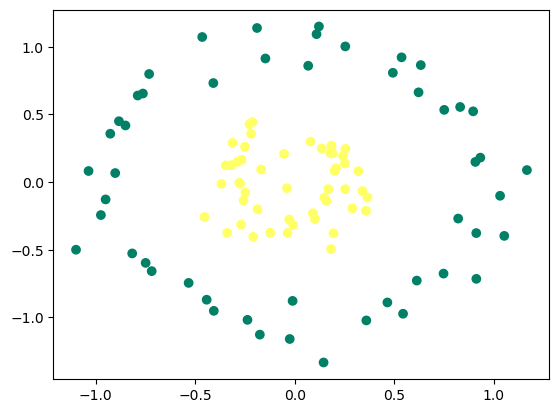

In [69]:
X, y = make_circles(n_samples=100, noise=0.1, factor=0.3, random_state=0)
X = X.T
y = y.reshape((1, y.shape[0]))

print('dimensions de X:', X.shape)
print('dimensions de y:', y.shape)

plt.scatter(X[0, :], X[1, :], c=y, cmap='summer')
plt.show()

# Exemple avec SGD

100%|██████████| 3000/3000 [00:05<00:00, 542.89it/s]


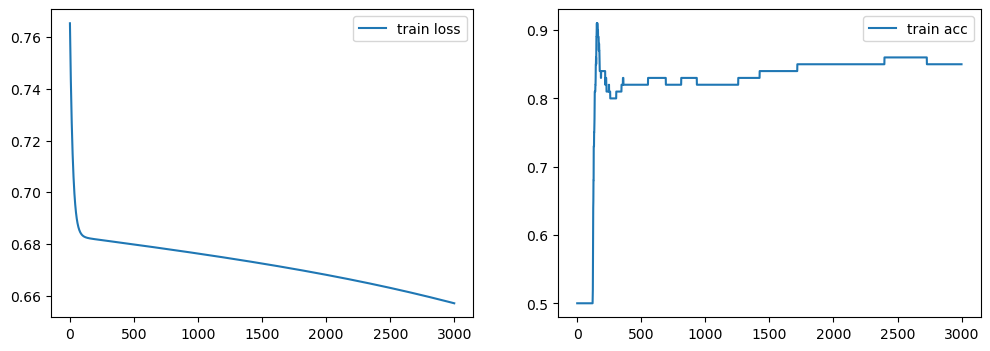

In [71]:
parametres_sgd, history_sgd = deep_neural_network(X, y, hidden_layers=(16, 16, 16), learning_rate=0.01, n_iter=3000, optimizer="sgd")

# Exemple avec Adam

In [ ]:
parametres_adam, history_adam = deep_neural_network(X, y, hidden_layers=(16, 16, 16), learning_rate=0.001, n_iter=3000, optimizer="adam")

 62%|██████▏   | 1855/3000 [00:02<00:01, 677.48it/s]

# Affichage des frontières de décisions 

In [ ]:
def plot_decision_boundary(X, y, parametres, title="Frontière de décision"):

    # Définir la grille de points
    x_min, x_max = X[0, :].min() - 0.1, X[0, :].max() + 0.1
    y_min, y_max = X[1, :].min() - 0.1, X[1, :].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    # Formater la grille pour prédire avec le modèle
    grid_points = np.c_[xx.ravel(), yy.ravel()].T
    activations = forward_propagation(grid_points, parametres)
    Z = activations[f"A{len(parametres) // 2}"]  # Dernière couche
    Z = Z.reshape(xx.shape)

    # Tracer les frontières et les données
    plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], alpha=0.8, cmap='summer')
    plt.scatter(X[0, :], X[1, :], c=y, cmap='summer', edgecolors='k')
    plt.title(title)
    plt.show()


In [ ]:
plot_decision_boundary(X, y, parametres_sgd, title="Frontière de décision - SGD")
plot_decision_boundary(X, y, parametres_adam, title="Frontière de décision - Adam")